R² Score: 0.497388
MSE: 0.000003
RMSE: 0.001612
MAE: 0.001252


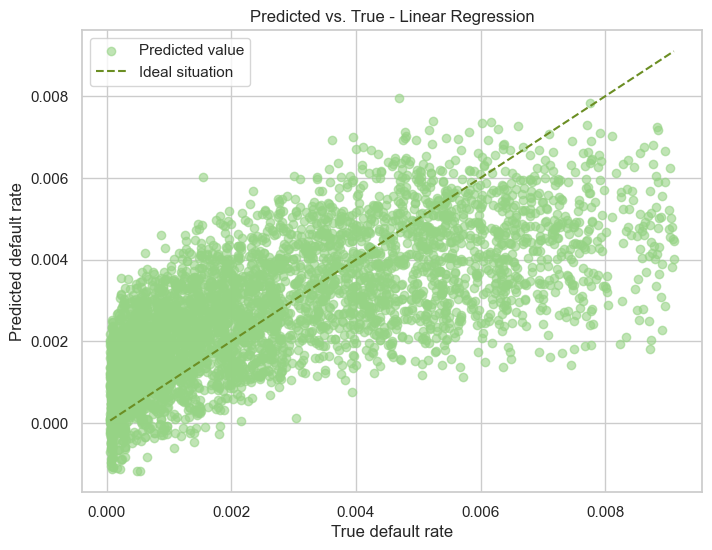

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1️⃣ 读取数据
file_path = "GreenLoan_cleaned.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ 处理异常值
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# 1️⃣ 需要转换的类别列
categorical_cols = ["Industry", "province"]

# 2️⃣ 创建一个字典存储 LabelEncoders
label_encoders = {}

# 3️⃣ 遍历每一列进行编码
for col in categorical_cols:
    le = LabelEncoder()  # 创建 LabelEncoder
    df[col] = le.fit_transform(df[col])  # 进行编码
    label_encoders[col] = le  # 保存编码器，以便以后解码

# 4️⃣ 选择特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])  # 特征
y = df["Green credit default rate"]  # 目标变量（连续变量）

# 5️⃣ 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7️⃣ 训练线性回归模型
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# 8️⃣ 预测
y_pred = linear_reg.predict(X_test)

# 9️⃣ 计算回归指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 🔟 打印结果
print(f"R² Score: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

# 1️⃣1️⃣ 绘制预测值 vs 真实值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="#96D385", label="Predicted value")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="olivedrab", linestyle="--", label="Ideal situation")
plt.xlabel("True default rate")
plt.ylabel("Predicted default rate")
plt.title("Predicted vs. True - Linear Regression")
plt.legend()
plt.show()

In [11]:
for col in df.columns:
    print(col)

Code
Year
Industry
Proportion of green credit loans
Proportion of interest expenses on green credit loans
Green credit default rate
Restricted industry for green credit
ESG score
Debt-to-asset ratio
ROA
Interest Expenses to Cash Flow Ratio
Cash to Total Assets
ROE
Current Ratio
Quick Ratio
Operating Cash Flow Ratio
mortgage
ST loan
Value book ratio
Inventory turnover ratio
Log(assets)
province
District code
green patent applications
green inventions
 utility model green patent applications
green patents granted
green invention patents authorized


Repeated Train/Val Split (Linear): 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]


Validation Set Performance:
R²        : 0.489711
RMSE      : 0.001623
MAE       : 0.001253
Spearman  : 0.747099
Test Set Performance:
R²        : 0.497487
RMSE      : 0.001612
MAE       : 0.001252
Spearman  : 0.743853


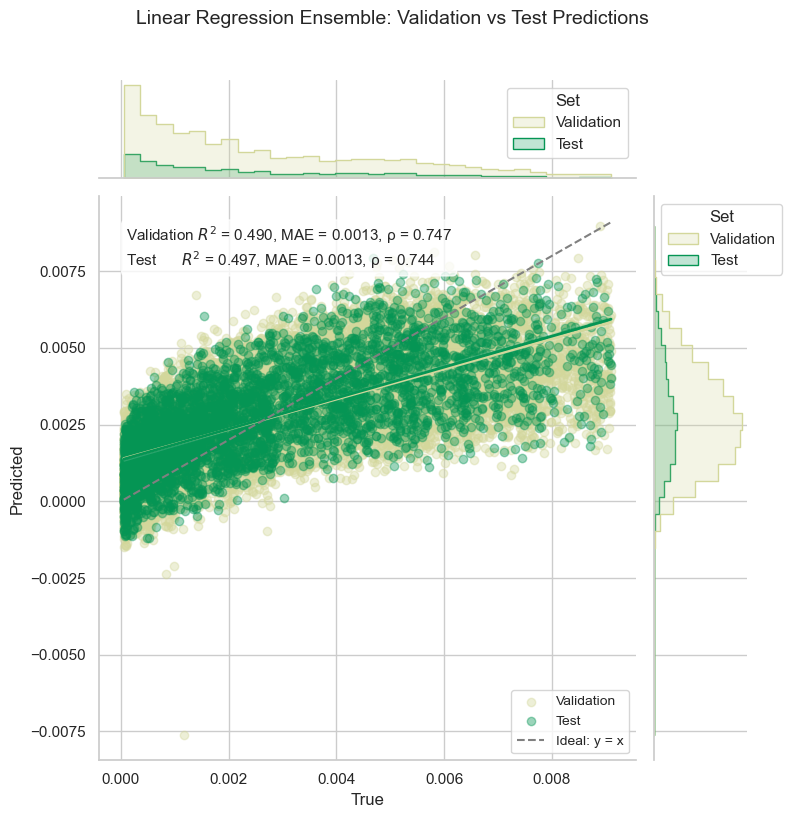

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr
from tqdm import tqdm

# 1️⃣ 读取数据
df = pd.read_excel("GreenLoan_cleaned.xlsx")

# 2️⃣ 清洗数据
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 3️⃣ 编码类别变量
categorical_cols = ["Industry", "province"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4️⃣ 特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])
y = df["Green credit default rate"]

# 5️⃣ 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 拆分训练集/测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 7️⃣ 多次训练
n_repeats = 500
results = []
y_test_preds = []
y_val_preds = []  # ✅ 保存验证集预测（含索引）

for i in tqdm(range(n_repeats), desc="Repeated Train/Val Split (Linear)"):
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=i
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_preds.append((y_val.index, y_val_pred))  # ✅ 保存验证集预测

    y_test_pred = model.predict(X_test)
    y_test_preds.append(y_test_pred)

    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)
        return r2, mse, rmse, mae, spearman_corr

    r2_val, mse_val, rmse_val, mae_val, spearman_val = evaluate(y_val, y_val_pred)
    r2_test, mse_test, rmse_test, mae_test, spearman_test = evaluate(y_test, y_test_pred)

    results.append({
        "run": i + 1,
        "R2_val": r2_val,
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "Spearman_val": spearman_val,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "Spearman_test": spearman_test
    })

# 8️⃣ 模型集成：对测试集预测结果取平均
y_test_ensemble_pred = np.mean(y_test_preds, axis=0)

# 9️⃣ 验证集预测平均（按索引）
val_pred_dict = {}
for idx, preds in y_val_preds:
    for i, row_id in enumerate(idx):
        if row_id not in val_pred_dict:
            val_pred_dict[row_id] = []
        val_pred_dict[row_id].append(preds[i])

val_avg_preds = {k: np.mean(v) for k, v in val_pred_dict.items()}

# 🔟 构建验证集 DataFrame
df_val = pd.DataFrame({
    "True": y_trainval.loc[val_avg_preds.keys()],
    "Predicted": list(val_avg_preds.values()),
    "Set": "Validation"
})

# 🔟 构建测试集 DataFrame
df_test = pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_ensemble_pred,
    "Set": "Test"
})

# 🔁 合并数据
df_plot = pd.concat([df_val, df_test], ignore_index=True)

# ✅ 计算评估指标
def evaluate_set(name, df):
    r2 = r2_score(df["True"], df["Predicted"])
    rmse = np.sqrt(mean_squared_error(df["True"], df["Predicted"]))
    mae = mean_absolute_error(df["True"], df["Predicted"])
    spearman_corr, _ = spearmanr(df["True"], df["Predicted"])
    print(f"{name} Set Performance:")
    print(f"R²        : {r2:.6f}")
    print(f"RMSE      : {rmse:.6f}")
    print(f"MAE       : {mae:.6f}")
    print(f"Spearman  : {spearman_corr:.6f}")
    return r2, rmse, mae, spearman_corr

r2_val, rmse_val, mae_val, spearman_val = evaluate_set("Validation", df_val)
r2_test, rmse_test, mae_test, spearman_test = evaluate_set("Test", df_test)

# 📈 可视化
sns.set(style="whitegrid")
palette = {"Validation": "#D3D79B", "Test": "#059554"}

g = sns.JointGrid(data=df_plot, x="True", y="Predicted", height=8)

# 散点 + 回归线
for label, color in palette.items():
    subset = df_plot[df_plot["Set"] == label]
    g.ax_joint.scatter(subset["True"], subset["Predicted"], alpha=0.4, color=color, label=label)
    sns.regplot(data=subset, x="True", y="Predicted", ax=g.ax_joint,
                scatter=False, color=color, line_kws={"linewidth": 2})

# 理想线
min_val = df_plot["True"].min()
max_val = df_plot["True"].max()
g.ax_joint.plot([min_val, max_val], [min_val, max_val], '--', color='gray', label="Ideal: y = x")

# 边缘直方图
sns.histplot(data=df_plot, x="True", hue="Set", ax=g.ax_marg_x,
             bins=30, element="step", common_norm=False, palette=palette)
sns.histplot(data=df_plot, y="Predicted", hue="Set", ax=g.ax_marg_y,
             bins=30, element="step", common_norm=False, palette=palette)

# 文本注释
g.ax_joint.text(
    0.05, 0.95,
    f"Validation $R^2$ = {r2_val:.3f}, MAE = {mae_val:.4f}, ρ = {spearman_val:.3f}\n"
    f"Test      $R^2$ = {r2_test:.3f}, MAE = {mae_test:.4f}, ρ = {spearman_test:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 图例和标题
g.ax_joint.legend(loc="lower right", fontsize=10)
plt.suptitle("Linear Regression Ensemble: Validation vs Test Predictions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()